# Influence des conditions météorologiques sur les réseaux sociaux
## Reddit
* Nous allons tout d'abord regarder l'influence de la météo sur le réseau reddit
* Reddit ne nous semble pas être le meilleur réseau social à étudier pour plusieurs raisons:
 * Les utilisateurs reddit sont contre la publicité et la mise en avant de produit
 * Dans un subreddit, ce n'est pas seulement l'entreprise qui poste mais aussi toute la communauté. Il n'est donc pas facile d'étudier les publications de l'entreprise elle-même.
* Pour notre analyse nous allons utiliser un subreddit d'un club de football Américain, la AustinFC. Notre choix s'est porté sur un tel subreddit car nous voulions trouver un subreddit dont les auteurs des commentaires seraient localisés. En effet, il y a une plus forte probabilité que les utilisateurs parlant de ce club vienne des alentours ce qui facilite l'observation des données météo.

## Twitter
* Dans un second temps nous allons regarder l'influence de la météo sur twitter
* Afin de comparer l'influence de la météo sur les deux réseaux sociaux, nous avons choisi la même cible, c'est à dire le AustinFC. Bien qu'il serait plus aisé de trouver une entreprise sur Twitter, notre choix s'est une nouvelle fois porté vers une cible dont les auteurs des réponses et commentaires risquaient d'être locaux.
* Twitter parait plus adapté à cette étude car nous pourrons bien étudier les réactions sur les tweets postés par l'entreprise elle même.

# Reddit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# read csv into pandas dataframes
reddit = pd.read_csv("reddit_AustinFC.csv", index_col = 0)
weather = pd.read_csv("weather_Austin.csv")

# display the 5 last lines of each datasets
display(reddit.tail())
display(weather.tail())

,title,score,num_comments,created date,created time
878,"The ""Oaks"" seems to be catching on as our nick...",10,13,23/08/2018,08:37:18
879,Austinfc.com registered (currently redirects t...,8,17,23/08/2018,06:55:49
880,New Crest Explained,8,0,23/08/2018,07:04:14
881,MLS franchise to be dubbed Austin FC,6,10,23/08/2018,05:56:39
882,Our new MLS team logo,4,2,23/08/2018,06:32:40


,created date,Highest Temperature,Lowest Temperature,Day Average Temperature,Precipitation,Max Wind Speed
659,06/11/2019,28.33,17.78,23.18,0.00,24.13
660,22/11/2018,16.67,10.00,13.33,0.76,12.87
661,20/07/2019,36.11,24.44,29.21,0.00,28.96
662,17/05/2019,32.78,23.33,27.22,0.00,33.79
663,17/03/2019,19.44,3.89,11.81,0.00,14.48


* Nous avons tout d'abord voulu créer un score de météo en fonction des paramètres à notre disposition. Nous avons pris en considération la différence à la moyenne des températures du mois en cours pour chaque date. A ce résultat, on veut retirer le poids des précipitations et le poids de la force du vent. Nous avons réparti les données du vent an quatre catégories suivant la force du vent. Nous avons raisonné de la même manière pour les précipitations que nous avons réparti en 3 catégories. Afin d'avoir des données positives, nous sommes parti d'un score de 20. score_meteo = 20 + difference à la moyenne - score precipitation - score vent
* Maintenant, nous désirons créer une variable pouvant représenter l'importance d'un post sur reddit. Nous avons décidé de prendre en compte le score du commentaire et les réponses à ceux-ci. Nous avons décidé de donner un poids plus important aux commentaires en partant d'un constat simple. Il est plus facile pour un utilisateur d'augmenter ou diminuer le score d'un post que de laisser un commentaire (cela demande davantage de temps). Le score reddit sera: score_reddit = score + 5 x nombre de commentaire

In [2]:
# The inner join also "delete" the reddit row where weather informations were not present for this date
reddit = pd.merge(reddit, weather, how="inner", on="created date", validate="m:1")

# apply a score to each wind speed category
reddit['wind_score'] = reddit['Max Wind Speed']
reddit.loc[reddit['Max Wind Speed'] <= 20, 'wind_score'] = 1
reddit.loc[((reddit['Max Wind Speed'] > 20) & (reddit['Max Wind Speed'] <= 30)), 'wind_score'] = 2
reddit.loc[((reddit['Max Wind Speed'] > 30) & (reddit['Max Wind Speed'] <= 40)), 'wind_score'] = 3
reddit.loc[reddit['Max Wind Speed'] > 40, 'wind_score'] = 4

# apply a score to each precipitation category
reddit['precipitation_score'] = reddit['Precipitation']
reddit.loc[reddit['Precipitation'] <= 1, 'precipitation_score'] = 1
reddit.loc[((reddit['Precipitation'] > 1) & (reddit['precipitation_score'] <= 90)), 'precipitation_score'] = 2
reddit.loc[reddit['Precipitation'] > 90, 'precipitation_score'] = 3

# list of dates in dataframe
month_list = []
for month in reddit["created date"] :
    array = month.split("/")
    month_list.append(f"{array[1]}/{array[2]}")
# creation of list with unique month
month_list = list(dict.fromkeys(month_list))
# application of mask to create value for each month
for month in month_list:
    mask = reddit["created date"].str.endswith(month)
    # all tweets start from a 20 rank
    reddit.loc[mask,"weather_score"] = 20 + reddit["Day Average Temperature"] - reddit.loc[mask, "Day Average Temperature"].mean() - reddit["wind_score"] - reddit["precipitation_score"]

# creation of reddi_score column
reddit["reddit_score"] = reddit.score + 5*reddit.num_comments

# delete row where there is no score and no response
reddit = reddit.drop(reddit[(reddit["reddit_score"] == 0)].index)

In [3]:
reddit.describe()

,score,num_comments,Highest Temperature,Lowest Temperature,Day Average Temperature,Precipitation,Max Wind Speed,wind_score,precipitation_score,weather_score,reddit_score
count,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000,881.000000
mean,24.919410,8.568672,27.384268,14.750874,20.646459,2.361169,26.152906,2.088536,1.163451,16.757432,67.762770
std,20.424008,11.150830,8.521643,9.038118,8.274126,9.011501,8.763218,0.837403,0.373045,3.806050,63.157176
min,0.000000,0.000000,5.000000,-17.780000,2.850000,0.000000,9.650000,1.000000,1.000000,0.539615,1.000000
25%,11.000000,2.000000,20.560000,6.670000,13.590000,0.000000,20.920000,2.000000,1.000000,14.950435,28.000000
50%,20.000000,5.000000,28.330000,17.220000,22.290000,0.000000,25.740000,2.000000,1.000000,17.012400,53.000000
75%,33.000000,12.000000,34.440000,23.330000,28.080000,0.000000,32.180000,3.000000,1.000000,18.907429,89.000000
max,157.000000,113.000000,40.560000,28.890000,34.090000,100.330000,65.970000,4.000000,3.000000,26.295263,603.000000


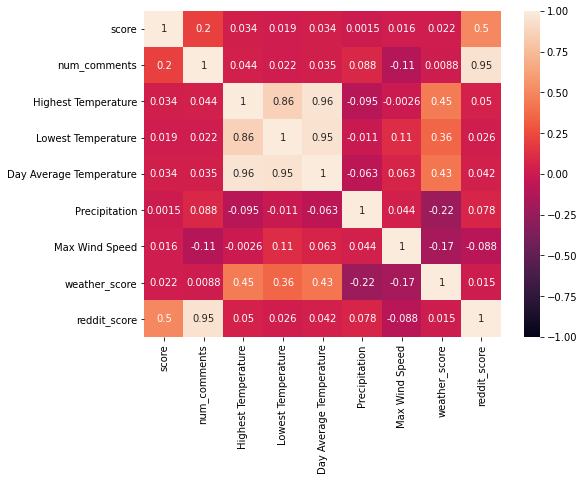

In [4]:
# display the heatmap without wind_score and precipitation score
fig, ax = plt.subplots(figsize=(8,6))
reddit_heat = reddit.drop(columns=["wind_score", "precipitation_score"])
sns.heatmap(reddit_heat.corr(),vmin=-1, vmax=1, annot=True, ax = ax)
plt.show()

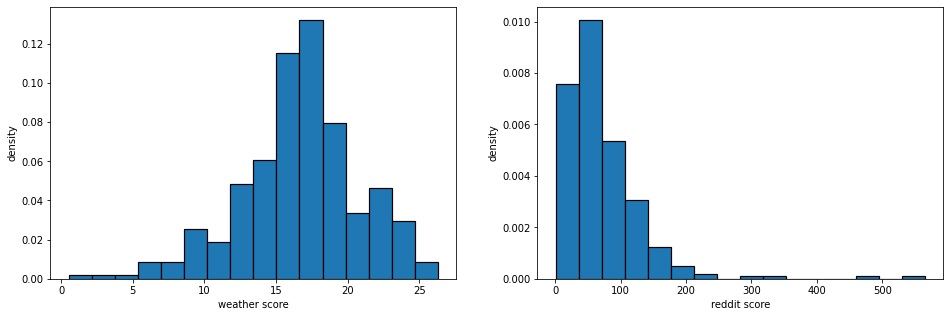

In [5]:
# function to filter by date
def df_by_month(df, year, month="all"):
    if month == "all":
        date = year
    else:   
        date = f"/{month}/{year}"
    final_df = df[df["created date"].str.endswith(date)]
    return final_df

# get the dataframe for 2019
reddit_2019 = df_by_month(reddit, "2019")

# show the repartition of weather score and reddit score in 2019
plt.figure(figsize = (16, 5))
plt.subplot(1, 2, 1)
n, bins, _ = plt.hist(reddit_2019["weather_score"], density=1, bins=16, edgecolor='black', linewidth=1.2)
plt.xlabel('weather score')
plt.ylabel('density')
plt.subplot(1, 2, 2)
n, bins, _ = plt.hist(reddit_2019["reddit_score"], density=1, bins=16, edgecolor='black', linewidth=1.2)
plt.xlabel('reddit score')
plt.ylabel('density')

plt.show()

* Il semble que le score meteo suive la répartition suivante, 15% des scores en dessous de 15, 30% entre 15 et 20 et 15% au dessus de 20. 
* Le score reddit montre une forte concentration dans les faibles valeurs.

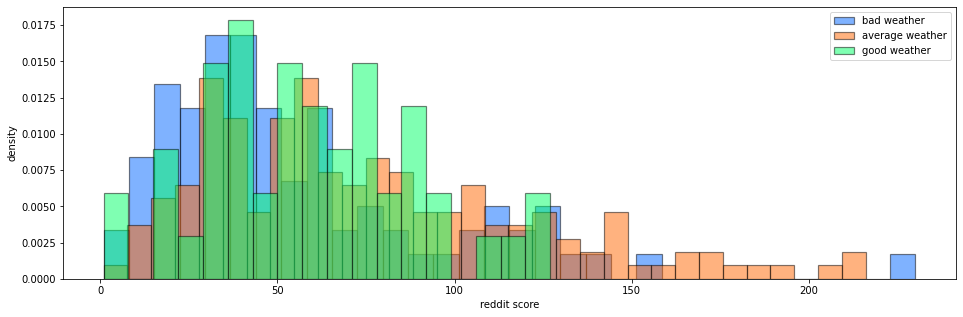

In [6]:
# selection of reddit score under 300
reddit_2019 = reddit_2019[reddit_2019["reddit_score"] < 300]
# repartition of weather score in 3 category, bad, average and good weather
bad_weather_reddit_2019 = reddit_2019[reddit_2019["weather_score"] < 15]
average_weather_reddit_2019 = reddit_2019[(reddit_2019["weather_score"] >= 15) & (reddit_2019["weather_score"] < 20)]
good_weather_reddit_2019 = reddit_2019[reddit_2019["weather_score"] >= 20]

plt.figure(figsize = (16, 5))
# drawing of reddit bad weather hist
n, bins, _ = plt.hist(bad_weather_reddit_2019["reddit_score"], density=1, bins=32,
                      edgecolor='black', linewidth=1.2, label='bad weather', color='#0066ff', alpha=.5)
# drawing of reddit average weather hist
plt.hist(average_weather_reddit_2019["reddit_score"], density=1, bins=32,
         edgecolor='black', linewidth=1.2, label='average weather', color='#ff6600', alpha=.5)
# drawing of reddit good weather hist
plt.hist(good_weather_reddit_2019["reddit_score"], density=1, bins=18,
         edgecolor='black', linewidth=1.2, label='good weather', color='#00ff66', alpha=.5)
plt.legend()
plt.xlabel('reddit score')
plt.ylabel('density')

plt.show()

On peut noter ici que le score reddit ne semble pas être influencé par les conditions météorologiques

# Twitter

In [7]:
twitter = pd.read_csv("twitter_AustinFC.csv", index_col = 0)
twitter.reset_index(inplace=True)
# drop useless columns
twitter = twitter.drop(columns=["created_at","tweet", "retweet", "urls", "link", "conversation_id", "user_id", "id", "timezone", "username", "name", "place", "language", "mentions", "photos", "hashtags", "cashtags", "quote_url", "video", "thumbnail", "near", "geo", "source", "user_rt_id", "user_rt", "retweet_id", "reply_to", "retweet_date", "translate", "trans_src", "trans_dest"])
pd.set_option("display.max_columns", None)

dates = []
# convert each date do the good format
for date in twitter["date"]:
    array = date.split("-")
    date = f"{array[2]}/{array[1]}/{array[0]}"
    dates.append(date)
dates = pd.DataFrame(dates)
twitter = twitter.drop(columns="date")
twitter["created date"] = dates

# delete rows where there is no replies and no retweets and no likes
twitter = twitter.drop(twitter[(twitter["replies_count"] == 0) & (twitter["retweets_count"] == 0) & (twitter["likes_count"] == 0)].index)

display(twitter.tail())

,time,replies_count,retweets_count,likes_count,created date
2789,17:56:08,1,0,1,12/06/2019
2791,17:55:01,0,0,1,12/06/2019
2792,17:54:52,0,0,1,12/06/2019
2794,17:53:35,1,0,0,12/06/2019
2799,17:51:45,1,0,1,12/06/2019


In [8]:
# The inner join also "delete" the reddit row where weather informations were not present for this date
twitter = pd.merge(twitter, weather, how="inner", on="created date", validate="m:1")

# creation of a twitter_score
twitter["twitter_score"] = twitter.likes_count + 5*twitter.replies_count

# apply a score to each wind speed
twitter['wind_score'] = twitter['Max Wind Speed']
twitter.loc[twitter['Max Wind Speed'] <= 20, 'wind_score'] = 1
twitter.loc[((twitter['Max Wind Speed'] > 20) & (twitter['Max Wind Speed'] <= 30)), 'wind_score'] = 2
twitter.loc[((twitter['Max Wind Speed'] > 30) & (twitter['Max Wind Speed'] <= 40)), 'wind_score'] = 3
twitter.loc[twitter['Max Wind Speed'] > 40, 'wind_score'] = 4

# apply a score to each wind speed
twitter['precipitation_score'] = twitter['Precipitation']
twitter.loc[twitter['Precipitation'] <= 1, 'precipitation_score'] = 1
twitter.loc[((twitter['Precipitation'] > 1) & (twitter['precipitation_score'] <= 90)), 'precipitation_score'] = 2
twitter.loc[twitter['Precipitation'] > 90, 'precipitation_score'] = 3

# list of dates in dataframe
month_list = []
for month in twitter["created date"] :
    array = month.split("/")
    month_list.append(f"{array[1]}/{array[2]}")
# creation of list with unique month
month_list = list(dict.fromkeys(month_list))
# application of mask to create value for each month
for month in month_list:
    mask = twitter["created date"].str.endswith(month)
    # all tweets start from a 20 rank
    twitter.loc[mask,"weather_score"] = 20 + twitter["Day Average Temperature"] - twitter.loc[mask, "Day Average Temperature"].mean() - twitter["wind_score"] - twitter["precipitation_score"]

twitter= twitter.drop(twitter[twitter["twitter_score"] > 500].index)

twitter.describe()

,replies_count,retweets_count,likes_count,Highest Temperature,Lowest Temperature,Day Average Temperature,Precipitation,Max Wind Speed,twitter_score,wind_score,precipitation_score,weather_score
count,2386.000000,2386.000000,2386.000000,2386.000000,2386.000000,2386.000000,2386.000000,2386.000000,2386.000000,2386.000000,2386.000000,2386.000000
mean,1.855407,5.952640,43.413244,27.452779,14.139816,20.567578,2.659732,25.747251,52.690277,2.044845,1.214585,16.759529
std,4.786911,10.723583,62.566066,8.425155,9.472589,8.228196,9.098369,9.587315,77.203415,0.894943,0.410620,4.340633
min,0.000000,0.000000,0.000000,3.890000,-17.780000,1.090000,0.000000,9.650000,0.000000,1.000000,1.000000,0.808736
25%,0.000000,0.000000,5.000000,21.670000,7.220000,13.450000,0.000000,19.310000,7.000000,1.000000,1.000000,14.908537
50%,1.000000,2.000000,21.000000,30.560000,18.890000,24.120000,0.000000,24.130000,24.000000,2.000000,1.000000,16.396207
75%,2.000000,7.000000,54.000000,34.440000,22.220000,28.070000,0.510000,32.180000,63.000000,3.000000,1.000000,18.618398
max,79.000000,127.000000,433.000000,38.890000,27.220000,31.740000,72.140000,65.970000,498.000000,4.000000,2.000000,26.780415


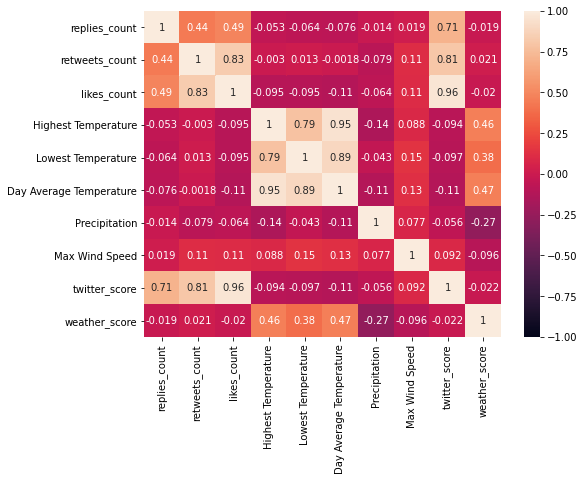

In [15]:
# display the heatmap without wind_score and precipitation score
fig, ax = plt.subplots(figsize=(8,6))
twitter_heat = twitter.drop(columns=["wind_score", "precipitation_score"])
sns.heatmap(twitter_heat.corr(),vmin=-1, vmax=1, annot=True, ax = ax)
plt.show()

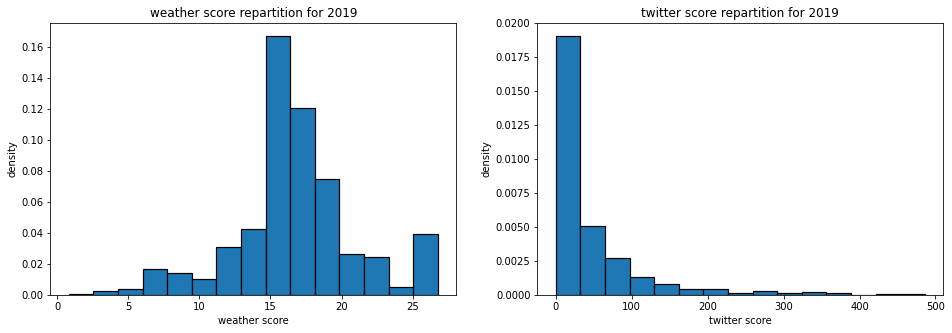

In [10]:
# keep only the results for the year 2019
twitter_2019 = df_by_month(twitter, "2019")

plt.figure(figsize = (16, 5))
# drawing of weather score for twitter in 2019
plt.subplot(1, 2, 1)
n, bins, _ = plt.hist(twitter_2019["weather_score"], density=1, bins=15, edgecolor='black', linewidth=1.2)
plt.xlabel('weather score')
plt.ylabel('density')
plt.title('weather score repartition for 2019')
# drawing of twitter score in 2019
plt.subplot(1, 2, 2)
n, bins, _ = plt.hist(twitter_2019["twitter_score"], density=1, bins=15, edgecolor='black', linewidth=1.2)
plt.xlabel('twitter score')
plt.ylabel('density')
plt.title('twitter score repartition for 2019')

plt.show()

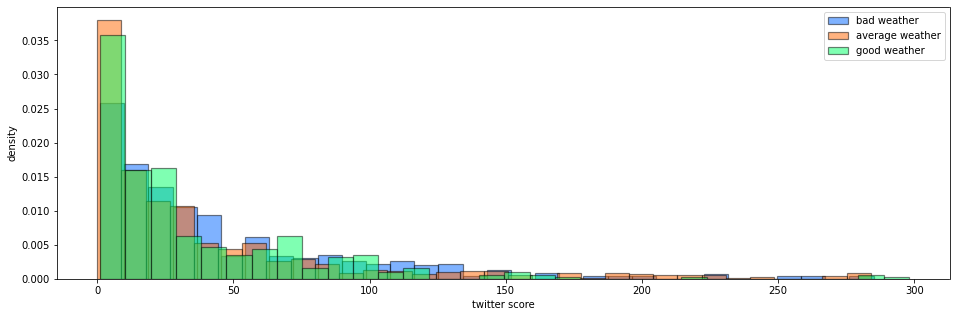

In [11]:
# selection of twitter score under 300
twitter_2019 = twitter_2019[twitter_2019["twitter_score"] < 300]
# repartition of weather score in 3 category, bad, average and good weather
bad_weather_twitter_2019 = twitter_2019[twitter_2019["weather_score"] < 15]
average_weather_twitter_2019 = twitter_2019[(twitter_2019["weather_score"] >= 15) & (twitter_2019["weather_score"] < 20)]
good_weather_twitter_2019 = twitter_2019[twitter_2019["weather_score"] >= 20]

plt.figure(figsize = (16, 5))
# drawing of twitter bad weather hist
n, bins, _ = plt.hist(bad_weather_twitter_2019["twitter_score"], density=1, bins=32,
                      edgecolor='black', linewidth=1.2, label='bad weather', color='#0066ff', alpha=.5)
# drawing of twitter average weather hist
plt.hist(average_weather_twitter_2019["twitter_score"], density=1, bins=32,
         edgecolor='black', linewidth=1.2, label='average weather', color='#ff6600', alpha=.5)
# drawing of twitter good weather hist
plt.hist(good_weather_twitter_2019["twitter_score"], density=1, bins=32,
         edgecolor='black', linewidth=1.2, label='good weather', color='#00ff66', alpha=.5)
plt.legend()
plt.xlabel('twitter score')
plt.ylabel('density')

plt.show()

/home/hugo/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/hugo/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/hugo/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


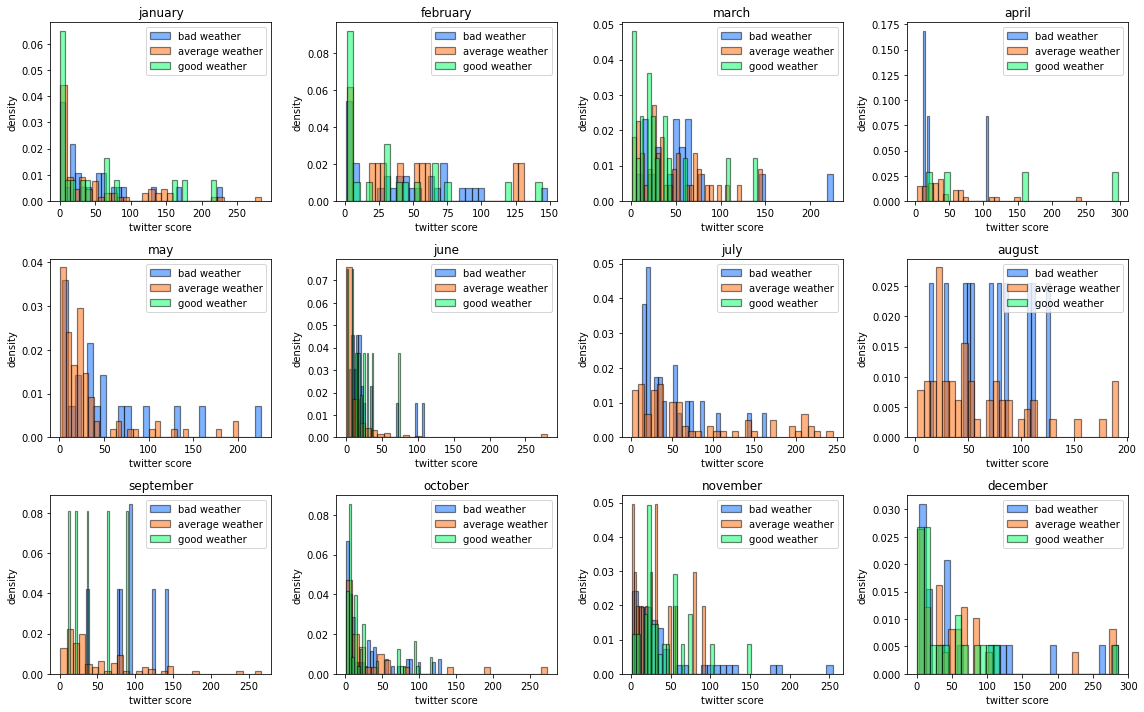

In [12]:
january_2019 = df_by_month(twitter, "2019", "01")
february_2019 = df_by_month(twitter, "2019", "02")
march_2019 = df_by_month(twitter, "2019", "03")
april_2019 = df_by_month(twitter, "2019", "04")
may_2019 = df_by_month(twitter, "2019", "05")
june_2019 = df_by_month(twitter, "2019", "06")
july_2019 = df_by_month(twitter, "2019", "07")
august_2019 = df_by_month(twitter, "2019", "08")
september_2019 = df_by_month(twitter, "2019", "09")
october_2019 = df_by_month(twitter, "2019", "10")
november_2019 = df_by_month(twitter, "2019", "11")
december_2019 = df_by_month(twitter, "2019", "12")


#def show_graph(df):
#    sns.scatterplot(x=df["weather_score"], y=df["twitter_score"])
#    plt.xlabel('weather score')
#    plt.ylabel('twitter score')

# function to display the twitter_score for weather category by dataframe
def hist_by_month(df):
    df = df[df["twitter_score"] < 300]
    bad_weather_twitter_2019 = df[df["weather_score"] < 15]
    average_weather_twitter_2019 = df[(df["weather_score"] >= 15) & (df["weather_score"] < 20)]
    good_weather_twitter_2019 = df[df["weather_score"] >= 20]
    
    plt.hist(bad_weather_twitter_2019["twitter_score"], density=1, bins=32,
             edgecolor='black', linewidth=1.2, label='bad weather', color='#0066ff', alpha=.5)
    plt.hist(average_weather_twitter_2019["twitter_score"], density=1, bins=32,
             edgecolor='black', linewidth=1.2, label='average weather', color='#ff6600', alpha=.5)
    plt.hist(good_weather_twitter_2019["twitter_score"], density=1, bins=32,
             edgecolor='black', linewidth=1.2, label='good weather', color='#00ff66', alpha=.5)
    plt.legend()
    plt.xlabel('twitter score')
    plt.ylabel('density')
    


plt.figure(figsize = (16, 10))
# plot twitter_score for weather category by month
plt.subplot(3, 4, 1)
hist_by_month(january_2019)
plt.title("january")
plt.subplot(3, 4, 2)
hist_by_month(february_2019)
plt.title("february")
plt.subplot(3, 4, 3)
hist_by_month(march_2019)
plt.title("march")
plt.subplot(3, 4, 4)
hist_by_month(april_2019)
plt.title("april")
plt.subplot(3, 4, 5)
hist_by_month(may_2019)
plt.title("may")
plt.subplot(3, 4, 6)
hist_by_month(june_2019)
plt.title("june")
plt.subplot(3, 4, 7)
hist_by_month(july_2019)
plt.title("july")
plt.subplot(3, 4, 8)
hist_by_month(august_2019)
plt.title("august")
plt.subplot(3, 4, 9)
hist_by_month(september_2019)
plt.title("september")
plt.subplot(3, 4, 10)
hist_by_month(october_2019)
plt.title("october")
plt.subplot(3, 4, 11)
hist_by_month(november_2019)
plt.title("november")
plt.subplot(3, 4, 12)
hist_by_month(december_2019)
plt.title("december")


plt.tight_layout()
plt.show()

## Comparaison reddit/twitter

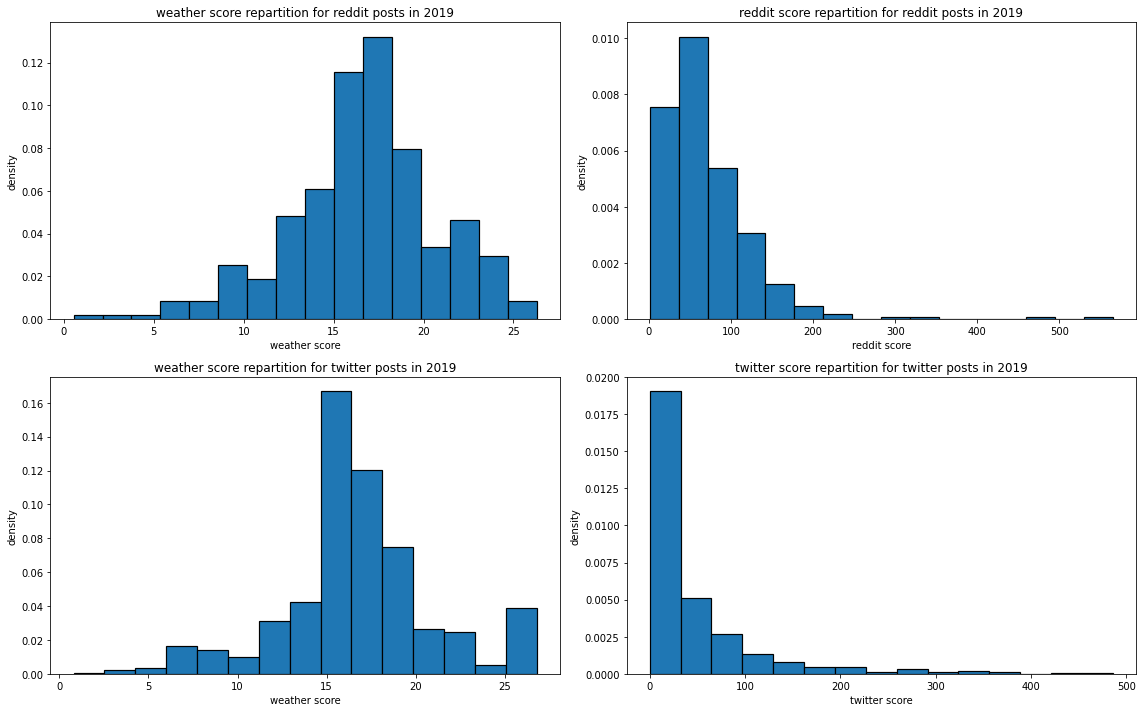

In [13]:
# selection of reddit and twiter post for 2019
reddit_2019 = df_by_month(reddit, "2019")
twitter_2019 = df_by_month(twitter, "2019")

plt.figure(figsize = (16, 10))
# drawing of reddit weather score
plt.subplot(2, 2, 1)
n, bins, _ = plt.hist(reddit_2019["weather_score"], density=1, bins=16, edgecolor='black', linewidth=1.2)
plt.xlabel('weather score')
plt.ylabel('density')
plt.title('weather score repartition for reddit posts in 2019')
# drawing of reddit score
plt.subplot(2, 2, 2)
n, bins, _ = plt.hist(reddit_2019["reddit_score"], density=1, bins=16, edgecolor='black', linewidth=1.2)
plt.xlabel('reddit score')
plt.ylabel('density')
plt.title('reddit score repartition for reddit posts in 2019')
# drawing of twitter weather score
plt.subplot(2, 2, 3)
n, bins, _ = plt.hist(twitter_2019["weather_score"], density=1, bins=15, edgecolor='black', linewidth=1.2)
plt.xlabel('weather score')
plt.ylabel('density')
plt.title('weather score repartition for twitter posts in 2019')
# drawing of twitter score
plt.subplot(2, 2, 4)
n, bins, _ = plt.hist(twitter_2019["twitter_score"], density=1, bins=15, edgecolor='black', linewidth=1.2)
plt.xlabel('twitter score')
plt.ylabel('density')
plt.title('twitter score repartition for twitter posts in 2019')

plt.tight_layout()
plt.show()

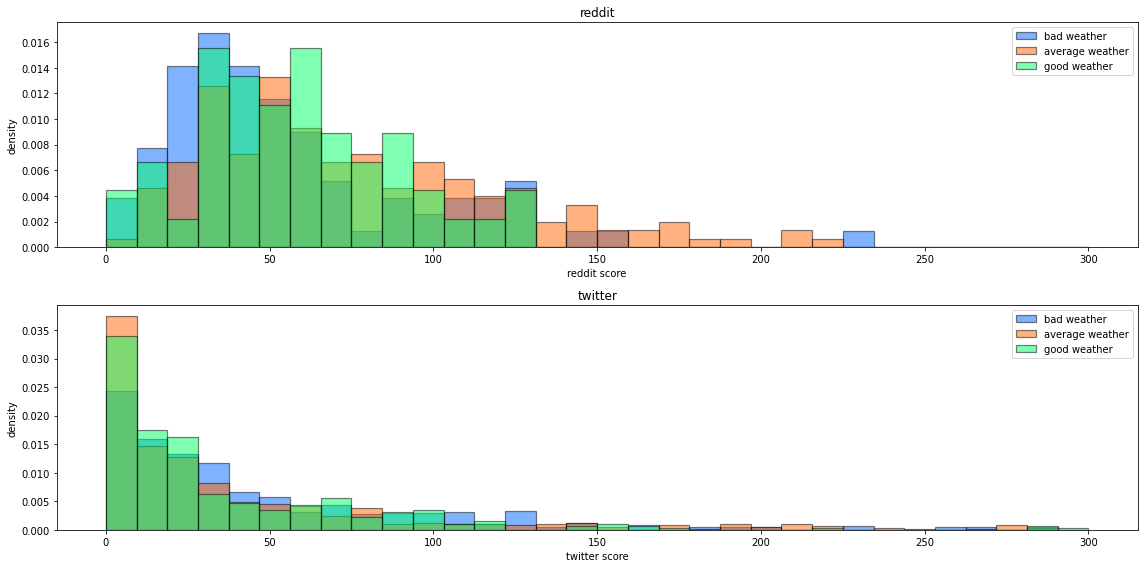

In [14]:
# selection of reddit score under 300
reddit_2019 = reddit_2019[reddit_2019["reddit_score"] < 300]
# repartition of weather score in 3 category, bad, average and good weather
bad_weather_reddit_2019 = reddit_2019[reddit_2019["weather_score"] < 15]
average_weather_reddit_2019 = reddit_2019[(reddit_2019["weather_score"] >= 15) & (reddit_2019["weather_score"] < 20)]
good_weather_reddit_2019 = reddit_2019[reddit_2019["weather_score"] >= 20]

plt.figure(figsize = (16, 8))
plt.subplot(2, 1, 1)
# drawing of reddit bad weather hist
n, bins, _ = plt.hist(bad_weather_reddit_2019["reddit_score"], density=1, bins=32, range=[0,300], 
                      edgecolor='black', linewidth=1.2, label='bad weather', color='#0066ff', alpha=.5)
# drawing of reddit average weather hist
plt.hist(average_weather_reddit_2019["reddit_score"], density=1, bins=32, range=[0,300], 
         edgecolor='black', linewidth=1.2, label='average weather', color='#ff6600', alpha=.5)
# drawing of reddit good weather hist
plt.hist(good_weather_reddit_2019["reddit_score"], density=1, bins=32, range=[0,300], 
         edgecolor='black', linewidth=1.2, label='good weather', color='#00ff66', alpha=.5)
plt.legend()
plt.xlabel('reddit score')
plt.ylabel('density')
plt.title('reddit')

# selection of twitter score under 300
twitter_2019 = twitter_2019[twitter_2019["twitter_score"] < 300]
# repartition of weather score in 3 category, bad, average and good weather
bad_weather_twitter_2019 = twitter_2019[twitter_2019["weather_score"] < 15]
average_weather_twitter_2019 = twitter_2019[(twitter_2019["weather_score"] >= 15) & (twitter_2019["weather_score"] < 20)]
good_weather_twitter_2019 = twitter_2019[twitter_2019["weather_score"] >= 20]

plt.subplot(2, 1, 2)

# drawing of twitter bad weather hist
n, bins, _ = plt.hist(bad_weather_twitter_2019["twitter_score"], density=1, bins=32, range=[0,300], 
                      edgecolor='black', linewidth=1.2, label='bad weather', color='#0066ff', alpha=.5)
# drawing of twitter average weather hist
plt.hist(average_weather_twitter_2019["twitter_score"], density=1, bins=32, range=[0,300], 
         edgecolor='black', linewidth=1.2, label='average weather', color='#ff6600', alpha=.5)
# drawing of twitter good weather hist
plt.hist(good_weather_twitter_2019["twitter_score"], density=1, bins=32, range=[0,300], 
         edgecolor='black', linewidth=1.2, label='good weather', color='#00ff66', alpha=.5)
plt.legend()
plt.xlabel('twitter score')
plt.ylabel('density')
plt.title('twitter')

plt.tight_layout()
plt.show()

Il parait l'évolution du score soit légèrement différente pour les deux résaux sociaux. Cependant même si l'allure gobale est différente la météo ne semble pas influer ces résultats.